# Analyse IMGEP Evaluation

In [1]:
from autodiscjax import DictTree
from autodiscjax.utils.timeseries import is_stable
import evaluation_config
import jax.numpy as jnp
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('text', usetex = True)
from matplotlib.colors import hsv_to_rgb
from sklearn.cluster import MeanShift, estimate_bandwidth

## Load experiment+evaluation history

In [2]:
experiment_history_filepath = "experiment_data/experiment_history.pickle"
experiment_history = DictTree.load(experiment_history_filepath)

evaluation_history_filepath = "evaluation_data/evaluation_history.pickle"
evaluation_history = DictTree.load(evaluation_history_filepath)

In [3]:
pipeline_config = evaluation_config.get_pipeline_config()
perturbation_config = evaluation_config.get_perturbation_config()

## Goals of the system

In [4]:
observed_node_ids = jnp.array([2,3])
ymax = jnp.array([7866.401, 4771.8975, 1377.4222, 1086.2181])
ymin = jnp.array([91.93025, 100.43926, 15.655377, 53.970665])

### Filter out non-convergent trajectories

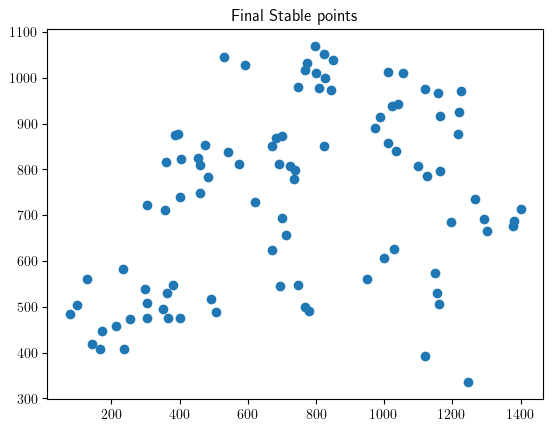

In [5]:
experiment_trajectories = experiment_history.system_output_library.ys[:, observed_node_ids, :]
is_stable_bool, mean_vals, std_vals = is_stable(experiment_trajectories, time_window=jnp.r_[-100:0], std_epsilon=1e-3*(ymax-ymin)[jnp.newaxis, observed_node_ids])
is_stable_bool = is_stable_bool.all(-1)
has_converged_ids = jnp.where(is_stable_bool)[0]

# goals = bins where they are final (stable) points
plt.figure()
plt.scatter(
    experiment_history.system_output_library.ys[has_converged_ids, observed_node_ids[0], -1],
    experiment_history.system_output_library.ys[has_converged_ids, observed_node_ids[1], -1],
)
plt.title("Final Stable points")
plt.show()

### Bin-based definition

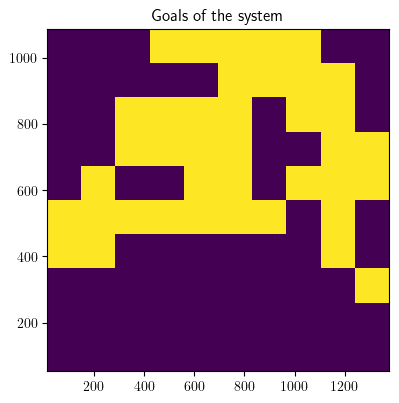

In [6]:
Hf, xedges, yedges = jnp.histogram2d(
    x=experiment_history.system_output_library.ys[has_converged_ids, observed_node_ids[0], -1],
    y=experiment_history.system_output_library.ys[has_converged_ids, observed_node_ids[1], -1],
    bins=10,
    range=jnp.stack(
        [ymin[observed_node_ids], ymax[observed_node_ids]]
    ).transpose(),
)
Hf = Hf.transpose() > 0
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(131, title="Goals of the system")
plt.imshow(
    Hf,
    interpolation="nearest",
    origin="lower",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect=(ymax[observed_node_ids[0]] - ymin[observed_node_ids[0]])
    / (ymax[observed_node_ids[1]] - ymin[observed_node_ids[1]]),
)
# plt.colorbar()
plt.show()

In [7]:
print(Hf.sum())

39


### Clustering-based definition

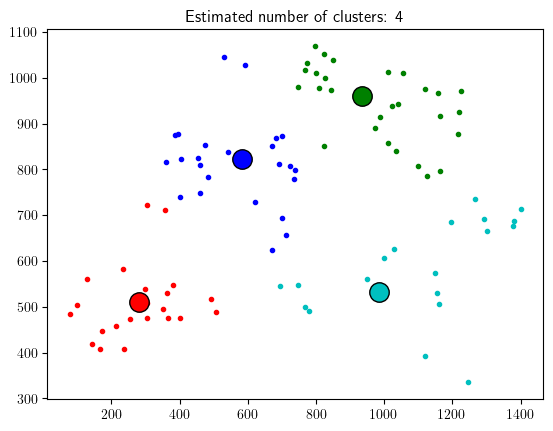

In [8]:
X = experiment_history.system_output_library.ys[:, observed_node_ids, -1][has_converged_ids]

# The following bandwidth can be automatically detected using
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = jnp.unique(labels)
n_clusters_ = len(labels_unique)

plt.figure(1)
plt.clf()

colors = "bgrcmyk"
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

## (Goal-directed) Robustness of the system

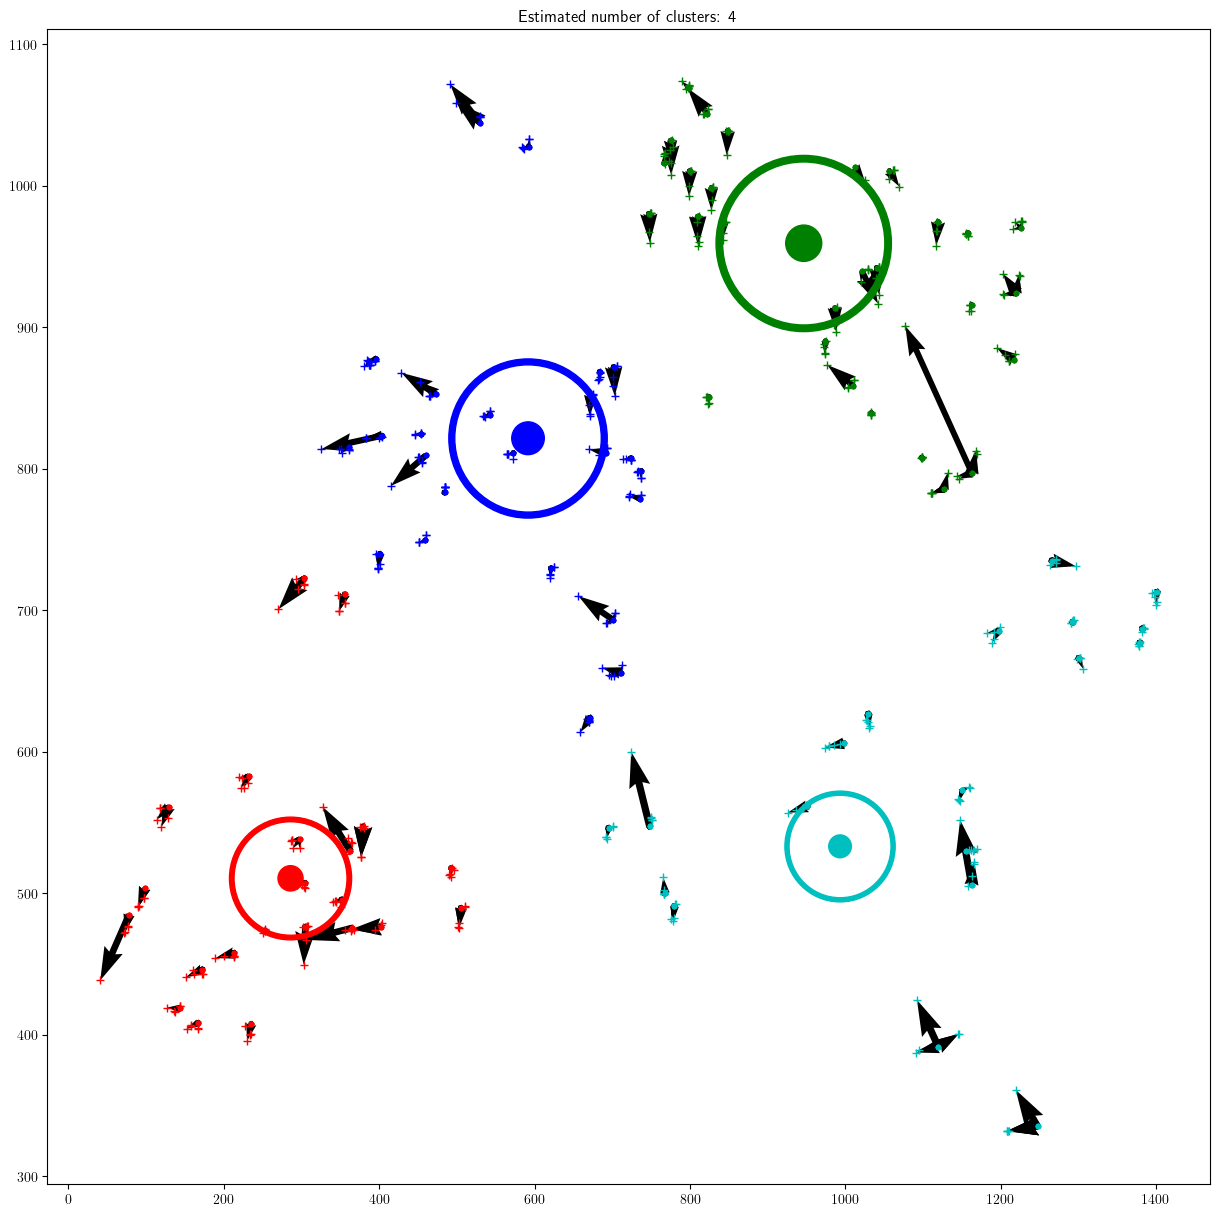

In [9]:
plt.figure(figsize=(15,15))
plt.clf()

#TODO: normalize distance

colors = "bgrcmyk"

for cluster_idx, col in zip(range(n_clusters_), colors):
    
    cluster_members = labels == cluster_idx
    cluster_center = cluster_centers[cluster_idx]
    cluster_X = jnp.repeat(experiment_history.system_output_library.ys[has_converged_ids, :, -1][cluster_members][...,observed_node_ids][:, jnp.newaxis, :], pipeline_config.n_perturbations, -2).reshape(-1, len(observed_node_ids))
    cluster_perturbed_X = evaluation_history.system_output_library.ys[has_converged_ids, :, :, -1][cluster_members][...,observed_node_ids].reshape(-1, len(observed_node_ids))
    
    #cluster_sensitivity = jnp.sqrt(((cluster_center[jnp.newaxis] - cluster_X)** 2).sum(-1))
    cluster_sensitivity = jnp.sqrt(((cluster_X - cluster_perturbed_X)** 2).sum(-1))
    cluster_robustness = 10*jnp.reciprocal(cluster_sensitivity.mean()).item()

    plt.plot(cluster_X[:, 0], cluster_X[:, 1], col + ".")
    plt.plot(cluster_perturbed_X[:, 0], cluster_perturbed_X[:, 1], col + "+")
    plt.quiver(cluster_X[:, 0], cluster_X[:, 1], cluster_perturbed_X[:, 0]-cluster_X[:, 0], cluster_perturbed_X[:, 1]-cluster_X[:, 1], angles='xy', scale_units='xy', scale=1)
    plt.scatter(
        [cluster_center[0]],
        [cluster_center[1]],
        marker=r'$\odot$',
        color=col,
        s=(10*cluster_robustness)**4,
    )

#plt.colorbar()
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

### Example trajectories

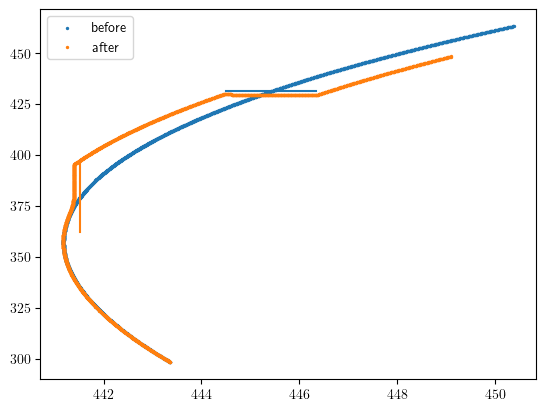

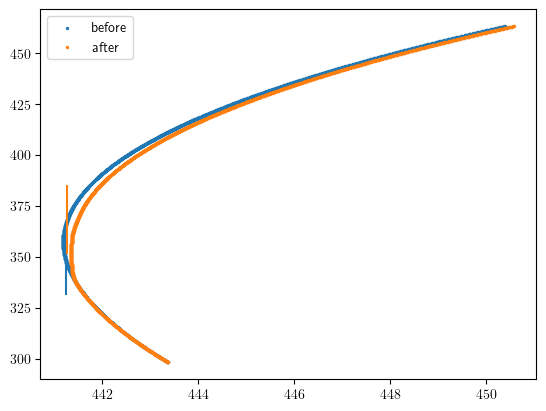

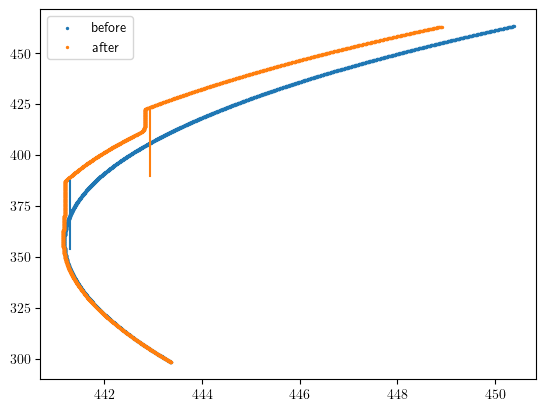

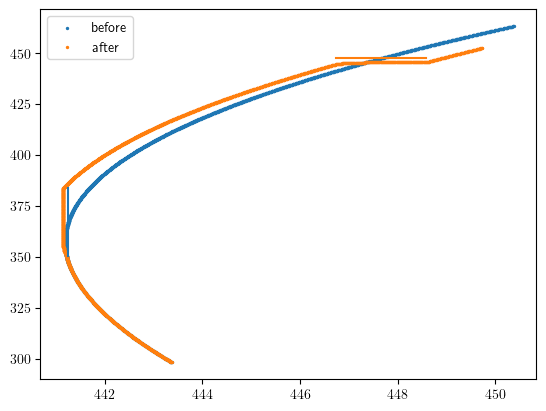

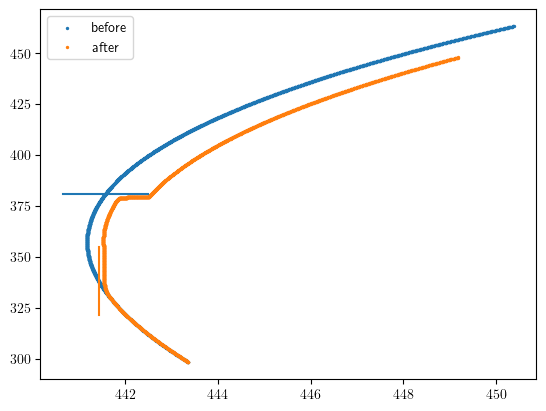

In [14]:
# Show results
sample_idx = 250
perturbed_node_ids = perturbation_config.perturbed_node_ids
for perturbation_idx in range(pipeline_config.n_perturbations):
    plt.figure()
    plt.scatter(experiment_history.system_output_library.ys[sample_idx, perturbed_node_ids[0]], experiment_history.system_output_library.ys[sample_idx, perturbed_node_ids[1]], s=2, label="before")
    plt.scatter(evaluation_history.system_output_library.ys[sample_idx, perturbation_idx, perturbed_node_ids[0]], evaluation_history.system_output_library.ys[sample_idx, perturbation_idx, perturbed_node_ids[1]], s=2, label="after")
    for wall_idx in range(perturbation_config.n_walls):
        plt.plot(evaluation_history.perturbation_params_library.y[perturbed_node_ids[0]][sample_idx, perturbation_idx, wall_idx].squeeze(),
                 evaluation_history.perturbation_params_library.y[perturbed_node_ids[1]][sample_idx, perturbation_idx, wall_idx].squeeze())
    plt.legend()
    plt.show()